In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
train_dir = "dataset_hg"
validation_dir = "valdataset_hg"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 258 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 233 files belonging to 2 classes.


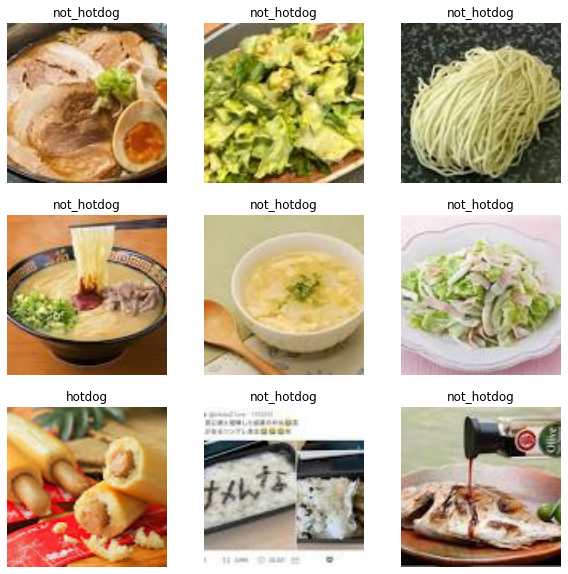

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

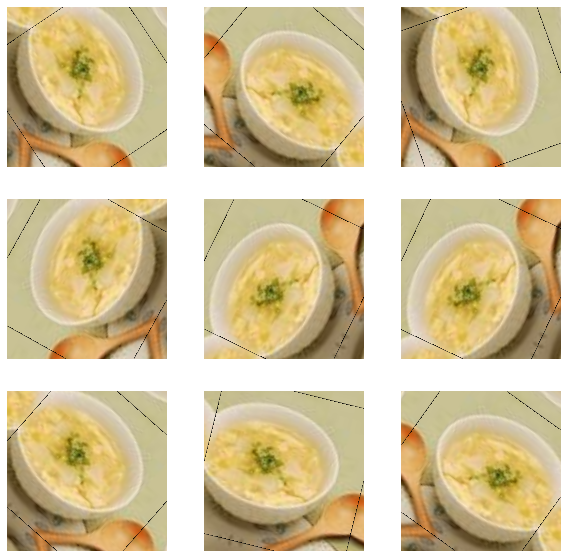

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False

In [16]:

# Let's take a look at the base model architecture
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [22]:
len(model.trainable_variables)

2

In [23]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 1s 99ms/step - loss: 0.8969 - accuracy: 0.4975


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.50


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
9/9 [==============================] - 2s 226ms/step - loss: 0.7785 - accuracy: 0.5504 - val_loss: 0.7975 - val_accuracy: 0.5522
Epoch 2/100
9/9 [==============================] - 2s 218ms/step - loss: 0.7492 - accuracy: 0.5698 - val_loss: 0.7751 - val_accuracy: 0.5721
Epoch 3/100
9/9 [==============================] - 2s 230ms/step - loss: 0.6866 - accuracy: 0.5853 - val_loss: 0.6997 - val_accuracy: 0.6418
Epoch 4/100
9/9 [==============================] - 2s 227ms/step - loss: 0.6791 - accuracy: 0.6318 - val_loss: 0.6638 - val_accuracy: 0.6965
Epoch 5/100
9/9 [==============================] - 2s 240ms/step - loss: 0.6492 - accuracy: 0.6357 - val_loss: 0.6438 - val_accuracy: 0.7214
Epoch 6/100
9/9 [==============================] - 2s 253ms/step - loss: 0.6370 - accuracy: 0.6512 - val_loss: 0.6052 - val_accuracy: 0.7662
Epoch 7/100
9/9 [==============================] - 2s 248ms/step - loss: 0.6546 - accuracy: 0.6395 - val_loss: 0.6054 - val_accuracy: 0.7711
Epoch 8/100
9

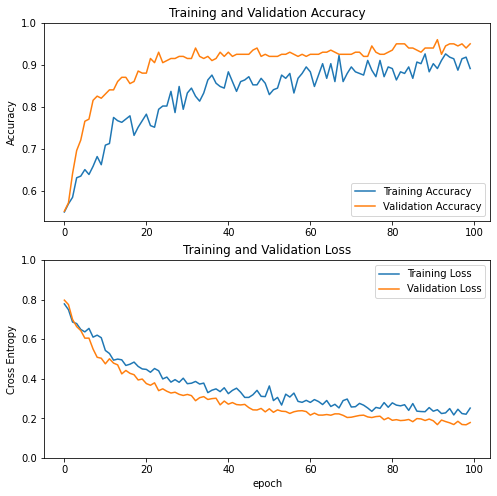

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 655us/step - loss: 0.2118 - accuracy: 0.9375
Test accuracy : 0.9375


Predictions:
 [1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0]
Labels:
 [1 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0]


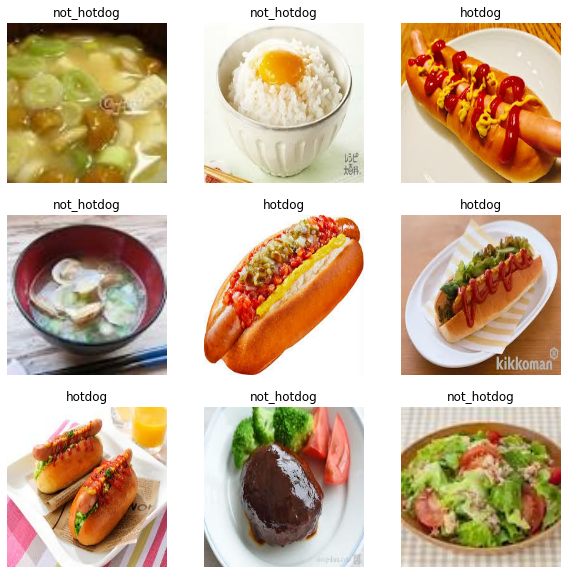

In [28]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [29]:
model.save('hotdog.h5')

In [45]:
model.save('saved_model/hotdog')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/hotdog/assets


In [47]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/hotdog")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open('./hotdog.tflite', 'wb') as w:
    w.write(tflite_quant_model)
print("Weight Quantization complete! - white_box_cartoonization_weight_quant.tflite")

In [1]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/hotdog")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open('./hotdog_noqt.tflite', 'wb') as w:
    w.write(tflite_quant_model)
print("Convert complete! - hotdog_noqt.tflite")

Convert complete! - hotdog_noqt.tflite


In [33]:
# converter = tf.lite.TFLiteConverter.from_keras_model('hotdog.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_model = converter.convert()
with open('./hotdog_h5.tflite', 'wb') as w:
    w.write(tf_model)
print("Convert complete! - hotdog_noqt.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpqd6fph1v/assets
INFO:tensorflow:Assets written to: /tmp/tmpqd6fph1v/assets
Convert complete! - hotdog_noqt.tflite


In [92]:
import tensorflow as tf
import numpy as np

interpreter = tf.lite.Interpreter(model_path="hotdog_h5.tflite")
interpreter.allocate_tensors()

print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype']) 

print(interpreter.get_output_details()[0]['shape'])  
print(interpreter.get_output_details()[0]['dtype']) 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

[  1 160 160   3]
<class 'numpy.float32'>
[1 1]
<class 'numpy.float32'>


In [93]:
import cv2

In [124]:
# img = cv2.imread('valdataset_hg/not_hotdog/rice_0.jpg')
img = cv2.imread('valdataset_hg/hotdog/hotdog_10.jpg')
in_img = cv2.resize(img, (160, 160))
in_img = in_img.transpose((2, 0, 1))
in_img = in_img.astype(np.float32)
in_img /= 255.0
in_img = in_img.reshape((1, 160, 160, 3))

In [125]:
interpreter.set_tensor(input_details[0]['index'], in_img)
interpreter.invoke()

In [126]:
out = interpreter.get_tensor(output_details[0]['index'])

In [127]:
predictions = tf.nn.sigmoid(out)
predictions = tf.where(predictions < 0.5, 0, 1)

In [128]:
predictions

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

In [129]:
out

array([[0.4486253]], dtype=float32)